In [ ]:
%%capture install
try:
  import imlms
  print('Already installed')
except:
  %pip install git+https://github.com/Mads-PeterVC/imlms

In [ ]:
print(install.stdout.splitlines()[-1])

In [135]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Trainable Interatomic Potentials

### Primer: A few more torch tips & tricks.

So far when when trained models using gradient descent we have done it in the most 
explicit way - but not the most convenient.

In [80]:
class LinearModel(torch.nn.Module):
    def __init__(self, a, b):
        super(LinearModel, self).__init__()
        self.a = torch.nn.Parameter(torch.tensor(a))
        self.b = torch.nn.Parameter(torch.tensor(b))
    def forward(self, x):
        return self.a * x + self.b

In [81]:
from imlms.torch import get_example_data

# Same data as in the previous example from lesson 2
X, y = get_example_data()

Again we want to train the model, but this time we use

- An `optimizer`: This class handles everything about updating the model parameters. 
- A `loss`-function, because we are use the very common mean-squared-error we can take that directly from torch

In [82]:
# Initialize the model 
model = LinearModel(a=0.5, b=0.5)
y_pred_initial = model(X) # Predictions with the initial model

# Create an optimizer, the optimizer is told the parameters to optimize e.g. all the parameters of the model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# If we want to optimize only a subset of the parameters we can do so by passing 
# a list of parameters to the optimizer. 
# For example we can optimize only the parameter a of the model, controlling the slope.
# optimizer = torch.optim.SGD([model.a], lr=0.01) # <--- Try this too!!

# Define the loss function
loss_fn = torch.nn.MSELoss()

# Run the optimization loop
for i in range(300):

    # Zero the gradients - this is needed because PyTorch otherwise accumulates the gradients.
    optimizer.zero_grad()

    # Forward pass: Make predictions and calculate the loss
    y_pred = model(X)
    loss = loss_fn(y_pred, y)

    # Backward pass: Calculate the gradients - this is instead of the 
    # torch.autograd.grad() function we used in the previous example
    loss.backward()

    # Update the parameters by taking a step with the optimizer
    optimizer.step()

    if i % 100 == 0:
        print(f'Loss: {l.item()}')

y_pred_final = model(X)

print(f'Final model: a={model.a.item():0.2f}, b={model.b.item():0.2f}')

Loss: 0.3067587614059448
Loss: 0.3067587614059448
Loss: 0.3067587614059448
Final model: a=1.79, b=-0.01


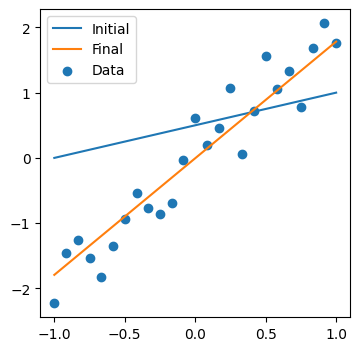

In [83]:
fig, ax = plt.subplots(figsize=(4, 4))

with torch.no_grad():
    ax.plot(X.detach().numpy(), y_pred_initial.detach().numpy(), label="Initial")
    ax.plot(X.detach().numpy(), y_pred_final.detach().numpy(), label="Final")
    ax.scatter(X.detach().numpy(), y.detach().numpy(), label="Data")

ax.legend()

### Example: Trainable Lennard Jones Potential

What we want to do now is to make the parameters `sigma` and `epsilon` learnable from 
data. This will enable us to fit the Lennard Jones potential as best as possible to 
a given dataset. 

To do this we will change a few things from our `LennardJonesTorch` class, 
we will make another called `LennardJonesModule` with these changes.

1. `LennardJonesModule` should *inherit* from `torch.nn.Module`. 
2. The parameters should be set as `torch.nn.Parameter` instances. 

In [136]:
class LennardJonesModule(torch.nn.Module):

    def __init__(self, sigma=1.0, epsilon=1.0):
        super().__init__()
        self.sigma = torch.nn.Parameter(torch.tensor(sigma))
        self.epsilon = torch.nn.Parameter(torch.tensor(epsilon))

    def get_lj_energy(self, r):
        # Calculate the Lennard-Jones energy using the class attributes 
        # self.sigma and self.epsilon.
        return 4 * self.epsilon * ((self.sigma/r)**12 - (self.sigma/r)**6)

    def forward(self, distances):
        """
        The 'distances'-tensor has shape (N, B) where N is the number of example
        configurations and B is the number of bonds in each configuration. 
        """
        # Sum the Lennard-Jones energy over all bonds in each configuration to get the total energy.
        E = torch.sum(self.get_lj_energy(distances), axis=1)
        return E

I have created a function that produces a dataset

In [137]:
from imlms.potentials import get_simple_lj_dataset

# # Generate a dataset
R, y = get_simple_lj_dataset(n_samples=25)

print(f"{R.shape = }")
print(f"{y.shape = }")

R.shape = torch.Size([25, 1])
y.shape = torch.Size([25])


The dataset contains 25 examples of dimers where

- `R`: The bond distances of the example configuration
- `y`: The total energy of the configuration

In [89]:
sigma_init = np.random.uniform(1.0, 2.0)
epsilon_init = np.random.uniform(1.0, 2.0)

model = LennardJonesModule(sigma=sigma_init, epsilon=epsilon_init)

# Define the optimizer: Different optimizer than in the previous example, but the same principle
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Define the loss function
loss_fn = torch.nn.MSELoss()

# Train the model
n_epochs = 10000

for epoch in range(n_epochs):

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    loss = 0
    y_pred = model(R)
    loss = loss_fn(y_pred, y)

    # Backward pass
    loss.backward()

    # Optimize
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: loss = {loss.item()}")

Epoch 0: loss = 3.900768518447876
Epoch 1000: loss = 2.835242041143715e-09
Epoch 2000: loss = 2.8182347566740873e-09
Epoch 3000: loss = 2.8986275601994294e-09
Epoch 4000: loss = 2.835242041143715e-09
Epoch 5000: loss = 2.9153290892480754e-09
Epoch 6000: loss = 2.9568127946077993e-09
Epoch 7000: loss = 0.0003447983181104064
Epoch 8000: loss = 6.4991030335193045e-09
Epoch 9000: loss = 2.5738760086824186e-05


If the loss doesn't really get very low try running the cell again.

In [90]:
for name, param in model.named_parameters():
    print(f"{name}: {param.data.item()}")

sigma: 1.7828993797302246
epsilon: 1.065826654434204


Text(0, 0.5, 'E [eV]')

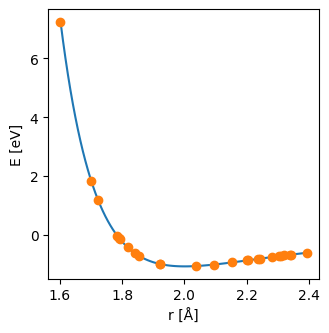

In [91]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

with torch.no_grad():
    R_cont = torch.linspace(R.min(), R.max(), 100).reshape(-1, 1)
    y_pred = model(R_cont)
    ax.plot(R_cont, y_pred, label='Predicted')

# Plot the true vs predicted energies
r_flat = R.flatten()
y_flat = y.flatten()
ax.plot(r_flat, y_flat, 'o')

ax.set_xlabel('r [Å]')
ax.set_ylabel('E [eV]')

### Exercise: Learning from clusters.

In the previous example the training data we used consisted of dimers and our model is a two-body model, 
so we could easily fit the data. 

Now things will be a little more difficult, our new dataset with consist of clusters with 12 atoms, 
but we still want to fit it with the same model.

In [138]:
from imlms.potentials.load_cluster_data import get_cluster_data

In [139]:
X, R, E = get_cluster_data(train=True)

print(f"{X.shape = }")
print(f"{R.shape = }")
print(f"{E.shape = }")

X.shape = torch.Size([300, 12, 2])
R.shape = torch.Size([300, 66])
E.shape = torch.Size([300])


In [146]:
sigma_init = np.random.uniform(1.0, 2.0)
epsilon_init = np.random.uniform(1.0, 2.0)

model = LennardJonesModule(sigma=sigma_init, epsilon=epsilon_init)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Define the loss function
loss_fn = torch.nn.MSELoss()

# Train the model
n_epochs = 10000

for epoch in range(n_epochs):

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    y_pred = model(R)
    loss = loss_fn(y_pred, E)

    # Backward pass
    loss.backward()

    # Optimize
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: loss = {loss.item()}")

Epoch 0: loss = 13265.8818359375
Epoch 1000: loss = 6.253223896026611
Epoch 2000: loss = 6.245672702789307
Epoch 3000: loss = 6.24567174911499
Epoch 4000: loss = 6.245674133300781
Epoch 5000: loss = 6.2456746101379395
Epoch 6000: loss = 6.245673179626465
Epoch 7000: loss = 6.2456746101379395
Epoch 8000: loss = 6.245673656463623
Epoch 9000: loss = 6.245674133300781


In [147]:
X_test, R_test, E_test = get_cluster_data(train=False)

with torch.no_grad():
    E_train_pred = model(R)
    E_test_pred = model(R_test)

In order to visualize the learning process we need to do something new this time, 
as the dataset isn't a nice 1D function we can just plot.

Instead we will create a *parity plot* where each for each datapoint we plot 
the true value vs the predicted value. If the model is perfect all the points 
should fall on a straight line. 

Another thing we are doing now is that we will make plots for the dataset we 
trained on and a dataset that we kept hidden from the model. This will help us 
detect overfitting.

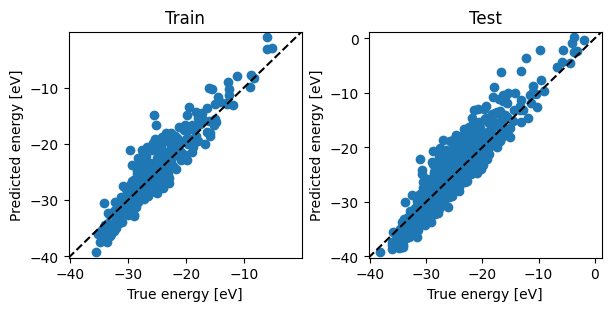

In [148]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), layout='constrained')

labels = ['Train', 'Test']
for ax, E_true, E_pred, label in zip(axes, [E, E_test], [E_train_pred, E_test_pred], labels):

    ax.plot(E_true, E_pred, 'o')

    ax.set_xlabel('True energy [eV]')
    ax.set_ylabel('Predicted energy [eV]')

    E_min = min(E.min(), E_pred.min()) - 1
    E_max = max(E.max(), E_pred.max()) + 1    
    ax.plot([E_min, E_max], [E_min, E_max], 'k--')
    ax.set_xlim(E_min, E_max)
    ax.set_ylim(E_min, E_max)

    ax.set_title(label)

We can generally not get a perfect fit, the cloud of points certainly follows the straight line 
but there are lots of places where the predictions are very wrong! 

### Exercise: More expressive potential

Our Lennard Jones potential from above is very limited in its form, so we can try making a 
model that has a little more freedom. 

In this case I will choose that we will add a number of Gaussians with some learnable parameters 
to the Lennard Jones predictions. To do so we will implemenet a `GaussianModule`-class. 

Recall that a Gaussian function is defined by 

$$
f(x) = A \exp{\left(-\frac{(r-r_0)^2}{2\sigma^2}\right)}
$$
Where the parameters are

- $A$: Controlling the amplitude
- $r_0$: Controlling the location
- $\sigma$: Controlling the width.

In [128]:
class GaussianModule(torch.nn.Module):

    def __init__(self, r0, A, sigma):
        super().__init__()
        self.r0 = torch.nn.Parameter(torch.tensor(r0), requires_grad=False)
        self.A = torch.nn.Parameter(torch.tensor(A))
        self.sigma = torch.nn.Parameter(torch.tensor(sigma))

    def forward(self, r):
        return self.A * torch.exp(-(r-self.r0)**2/(2*self.sigma**2)).sum(axis=1)

Next we can create a new model that uses both our `LennardJonesModule` and our `GaussianModule`. 

Torch makes this simple, we can just set the modules as properties of our new class

In [129]:
class Model(torch.nn.Module):

    def __init__(self, N_basis, r_max, sigma_lj, epsilon_lj):
        super().__init__()
        # Create Gaussians with centers from 0 to r_max
        self.rbf = torch.nn.ModuleList([GaussianModule(r0.item(), 0.1, 0.1) for r0 in torch.linspace(0, r_max, N_basis)])

        # Create the Lennard-Jones module
        self.lj = LennardJonesModule(sigma=sigma_lj, epsilon=epsilon_lj)

    def forward(self, R):
        # Calculate the Lennard-Jones energy
        E = self.lj(R)

        # Calculate the contribution from each Gaussian
        for rbf in self.rbf:
            E += rbf(R)
        return E

The training loop is the same as before

In [130]:
X, R, E = get_cluster_data(train=True)

sigma_init = 1.0
epsilon_init = 1.0

model = Model(N_basis=10, r_max=3.0, sigma_lj=sigma_init, epsilon_lj=epsilon_init)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Define the loss function
loss_fn = torch.nn.MSELoss()

# Train the model
n_epochs = 5000

for epoch in range(n_epochs):

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    loss = 0
    y_pred = model(R)
    loss = loss_fn(y_pred, E)

    # Backward pass
    loss.backward()

    # Optimize
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: loss = {loss.item()}")

Epoch 0: loss = 6635.41064453125
Epoch 1000: loss = 0.6861631870269775
Epoch 2000: loss = 0.17484445869922638
Epoch 3000: loss = 0.07103945314884186
Epoch 4000: loss = 0.05116548389196396


In [131]:
X_test, R_test, E_test = get_cluster_data(train=False)

with torch.no_grad(): 
    E_train_pred = model(R)
    E_test_pred = model(R_test)

We again make parity-plots

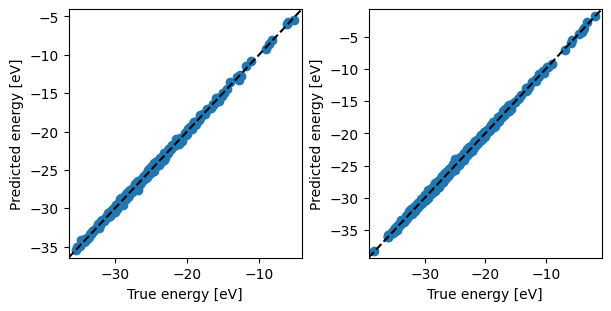

In [132]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), layout='constrained')

for ax, E_true, E_pred in zip(axes, [E, E_test], [E_train_pred, E_test_pred]):

    ax.plot(E_true, E_pred, 'o')

    ax.set_xlabel('True energy [eV]')
    ax.set_ylabel('Predicted energy [eV]')

    E_min = min(E.min(), E_pred.min()) - 1
    E_max = max(E.max(), E_pred.max()) + 1

    ax.plot([E_min, E_max], [E_min, E_max], 'k--')
    ax.set_xlim(E_min, E_max)
    ax.set_ylim(E_min, E_max)

You should be able to get parity plots that are nearly perfect, with all points being very close to the straight line.

We can inspect the form of the potential that our model has learned

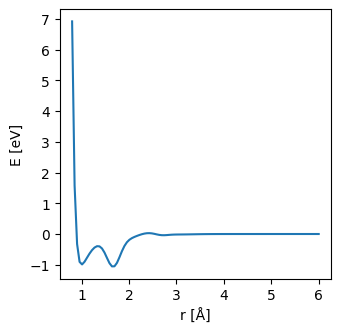

In [134]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

R = torch.linspace(0.8, 6.0, 100)

with torch.no_grad():

    E = model(R.reshape(-1, 1))
    ax.plot(R, E)

    ax.set_xlabel('r [Å]')
    ax.set_ylabel('E [eV]')